In [1]:
# enable pyspark
import findspark
findspark.init()

In [2]:
'''
Scripts instantiates a SparkSession locally with 8 worker threads.
'''
appName = "PySpark Partition"
master = "local[8]"
from pyspark import SparkContext, SparkConf
# ref: https://towardsai.net/p/programming/pyspark-aws-s3-read-write-operations
#spark configuration
conf = SparkConf().set('spark.executor.extraJavaOptions','-Dcom.amazonaws.services.s3.enableV4=true'). \
 set('spark.driver.extraJavaOptions','-Dcom.amazonaws.services.s3.enableV4=true'). \
 setAppName(appName).setMaster(master)

sc=SparkContext(conf=conf)
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')

# read aws credentials
import configparser
config = configparser.ConfigParser()
config.read_file(open(r'C:\Users\padma\.aws\credentials'))

accessKeyId= config['default']['AWS_ACCESS_KEY_ID']
secretAccessKey= config['default']['AWS_SECRET_ACCESS_KEY']

hadoopConf = sc._jsc.hadoopConfiguration()
hadoopConf.set('fs.s3a.access.key', accessKeyId)
hadoopConf.set('fs.s3a.secret.key', secretAccessKey)
hadoopConf.set('fs.s3a.endpoint', 's3.amazonaws.com')
hadoopConf.set('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')

print(sc)
from pyspark.sql import SparkSession
spark=SparkSession(sc)

<SparkContext master=local[8] appName=PySpark Partition>


In [3]:
import sys
print(sys.executable)

c:\users\padma\appdata\local\programs\python\python38\python.exe


In [4]:
import psutil

current_process = psutil.Process()
print(f'Parent process: {current_process}')
children = current_process.children(recursive=True)
count_child_threads = 0
for child in children:
    print('Child pid is {}'.format(child.pid))
    count_child_threads +=1
if count_child_threads == 0:
    print('No child threads associated')
else:
    print(f'{count_child_threads} child threads associated')

Parent process: psutil.Process(pid=9592, name='python.exe', status='running', started='22:00:09')
Child pid is 20936
Child pid is 25840
Child pid is 24528
3 child threads associated


## Data partitioning 
Data partitioning is critical to data processing performance especially for large volume of data processing in Spark. 
Partitions in Spark won’t span across nodes though one node can contains more than one partitions. When processing,
Spark assigns one task for each partition and each worker threads can only process one task at a time. Thus, 
with too few partitions, the application won’t utilize all the cores available in the cluster and it can cause 
data skewing problem; with too many partitions, it will bring overhead for Spark to manage too many small tasks.

In [5]:
'''
Scripts to populate a data frame with 100 records.
'''

from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql import SparkSession
from datetime import date, timedelta
from pyspark.sql.types import IntegerType, DateType, StringType, StructType, StructField

print(spark.version)
# Populate sample data
start_date = date(2019, 1, 1)
data = []
for i in range(0, 50):
    data.append({"Country": "CN", "Date": start_date +
                 timedelta(days=i), "Amount": 10+i})
    data.append({"Country": "AU", "Date": start_date +
                 timedelta(days=i), "Amount": 10+i})

schema = StructType([StructField('Country', StringType(), nullable=False),
                     StructField('Date', DateType(), nullable=False),
                     StructField('Amount', IntegerType(), nullable=False)])

df = spark.createDataFrame(data, schema=schema)
df.show()
print(df.rdd.getNumPartitions())

3.1.2
+-------+----------+------+
|Country|      Date|Amount|
+-------+----------+------+
|     CN|2019-01-01|    10|
|     AU|2019-01-01|    10|
|     CN|2019-01-02|    11|
|     AU|2019-01-02|    11|
|     CN|2019-01-03|    12|
|     AU|2019-01-03|    12|
|     CN|2019-01-04|    13|
|     AU|2019-01-04|    13|
|     CN|2019-01-05|    14|
|     AU|2019-01-05|    14|
|     CN|2019-01-06|    15|
|     AU|2019-01-06|    15|
|     CN|2019-01-07|    16|
|     AU|2019-01-07|    16|
|     CN|2019-01-08|    17|
|     AU|2019-01-08|    17|
|     CN|2019-01-09|    18|
|     AU|2019-01-09|    18|
|     CN|2019-01-10|    19|
|     AU|2019-01-10|    19|
+-------+----------+------+
only showing top 20 rows

8


In [6]:
# Write data frame to file system
# 8 sharded files will be generated for each partition under folder data/example.csv
# 7 shards/files with 12 rows and one file with 16 rows
df.count()
df.write.mode("overwrite").csv("data/example.csv", header=True)


## Repartitioning with coalesce function
This function is defined as the following:
<pre>
def coalesce(numPartitions)
Returns a new :class:DataFrame that has exactly numPartitions partitions.
</pre>

This operation results in a narrow dependency, e.g. if you go from 1000 partitions to 100 partitions, there will not be a shuffle, instead each of the 100 new partitions will claim 10 of the current partitions. If a larger number of partitions is requested, it will stay at the current number of partitions.

See below:
Now if we run the following code, can you guess how many sharded files will be generated?
The answer is still 8. **This is because coalesce function does’t involve reshuffle of data.** 
In the code below, we want to increase the partitions to 16 but the number of partitions
stays at the current (8)

In [7]:
df = df.coalesce(16)
print(df.rdd.getNumPartitions())
df.write.mode("overwrite").csv("data/example.csv", header=True)

8


If we decrease the partitions to 4 by running the following code, how many files will be generated? The answer is 4 

In [8]:
df = df.coalesce(4)
print(df.rdd.getNumPartitions())
df.write.mode("overwrite").csv("data/example.csv", header=True)

4


## Repartitioning with repartition function
The other method for repartitioning is repartition. It’s defined as the follows:
<pre>
def repartition(numPartitions, *cols)
</pre>
Returns a new :class:DataFrame partitioned by the given partitioning expressions. The resulting DataFrame is hash partitioned.

numPartitions can be an int to specify the target number of partitions or a Column. If it is a Column, it will be used as the first partitioning column. If not specified, the default number of partitions is used.

Added optional arguments to specify the partitioning columns. Also made numPartitions
optional if partitioning columns are specified.

Data reshuffle occurs when using this function. Let’s try some examples using the above dataset.

### Repartition by number
Use the code below to repartition the data to 10 partitions.
Spark will try to evenly distribute the data to each partitions. If the total partition number is greater than the actual record count (or RDD size), some partitions will be empty. After we run the above code, data will be reshuffled to 10 partitions with 10 sharded files generated.

If we repartition the data frame to 1000 partitions, how many sharded files will be generated?
The answer is 100 because the other 900 partitions are empty and each file has one record.

In [9]:
df = df.repartition(1000)
print(df.rdd.getNumPartitions())
df.write.mode("overwrite").csv("data/example.csv", header=True)

1000


### Repartition by column
We can also repartition by columns.
For example, let’s run the code below to repartition the data by column Country.
This will create 200 partitions (**Spark by default create 200 partitions**).  However only three sharded files are generated:
- One file stores data for CN country.
- Another file stores data for AU country.
- The other one is empty.

In [10]:
df = df.repartition("Country")
print(df.rdd.getNumPartitions())
df.write.mode("overwrite").csv("data/example.csv", header=True)

200


Similarly, if we can also partition the data by Date column:
<pre>
df = df.repartition("Date")
print(df.rdd.getNumPartitions())
df.write.mode("overwrite").csv("data/example.csv", header=True)
</pre>
If you look into the data, you may find the data is probably not partitioned properly as you would expect, for example, one partition file only includes data for both countries and different dates too.

**This is because by default Spark use hash partitioning as partition function**. You can use range partitioning function or customize the partition functions.

### Partition by multiple columns
In real world, you would probably partition your data by multiple columns. To implement the multiple column partitioning strategy, we need to derive some new columns (year, month, date). Code below derives some new columns and then repartition the data frame with those columns.

When you look into the saved files, you may find that all the new columns are also saved and the files still mix different sub partitions. To improve this, we need to match our write partition keys with repartition keys.

In [11]:
# derive some new columns (year, month, date)
df = df.withColumn("Year", year("Date")).withColumn(
"Month", month("Date")).withColumn("Day", dayofmonth("Date"))
# repartition the data frame with new columns
df = df.repartition("Year", "Month", "Day", "Country")
df.show()
print(df.rdd.getNumPartitions())
df.write.mode("overwrite").csv("data/example.csv", header=True)

+-------+----------+------+----+-----+---+
|Country|      Date|Amount|Year|Month|Day|
+-------+----------+------+----+-----+---+
|     AU|2019-01-21|    30|2019|    1| 21|
|     CN|2019-01-29|    38|2019|    1| 29|
|     AU|2019-01-19|    28|2019|    1| 19|
|     AU|2019-02-02|    42|2019|    2|  2|
|     AU|2019-02-07|    47|2019|    2|  7|
|     AU|2019-02-05|    45|2019|    2|  5|
|     AU|2019-02-08|    48|2019|    2|  8|
|     CN|2019-01-27|    36|2019|    1| 27|
|     CN|2019-01-21|    30|2019|    1| 21|
|     CN|2019-01-25|    34|2019|    1| 25|
|     CN|2019-02-06|    46|2019|    2|  6|
|     AU|2019-01-11|    20|2019|    1| 11|
|     CN|2019-01-19|    28|2019|    1| 19|
|     CN|2019-02-19|    59|2019|    2| 19|
|     AU|2019-02-03|    43|2019|    2|  3|
|     AU|2019-02-09|    49|2019|    2|  9|
|     CN|2019-01-14|    23|2019|    1| 14|
|     AU|2019-01-16|    25|2019|    1| 16|
|     CN|2019-02-16|    56|2019|    2| 16|
|     AU|2019-01-10|    19|2019|    1| 10|
+-------+--

### partitionBy
When you look into the saved files, you may find that all the new columns are also saved and the files still mix different sub partitions. To improve this, we need to match our write partition keys with repartition keys.
To match partition keys, we just need to change the last line to add a partitionBy function:

When you open the generated files, you will also find that all the partitioning columns/keys are removed from the serialized data files.
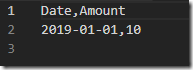
In this way, the storage cost is also less. With partitioned data, we can also easily append data to new subfolders instead of operating on the complete data set.

In [12]:
# derive some new columns (year, month, date)
df = df.withColumn("Year", year("Date")).withColumn(
"Month", month("Date")).withColumn("Day", dayofmonth("Date"))
# repartition the data frame with new columns
df = df.repartition("Year", "Month", "Day", "Country")
df.show()
print(df.rdd.getNumPartitions())
df.write.partitionBy("Year", "Month", "Day", "Country").mode(
"overwrite").csv("data/example.csv", header=True)

+-------+----------+------+----+-----+---+
|Country|      Date|Amount|Year|Month|Day|
+-------+----------+------+----+-----+---+
|     AU|2019-01-21|    30|2019|    1| 21|
|     CN|2019-01-29|    38|2019|    1| 29|
|     AU|2019-01-19|    28|2019|    1| 19|
|     AU|2019-02-02|    42|2019|    2|  2|
|     AU|2019-02-07|    47|2019|    2|  7|
|     AU|2019-02-05|    45|2019|    2|  5|
|     AU|2019-02-08|    48|2019|    2|  8|
|     CN|2019-01-27|    36|2019|    1| 27|
|     CN|2019-01-21|    30|2019|    1| 21|
|     CN|2019-01-25|    34|2019|    1| 25|
|     CN|2019-02-06|    46|2019|    2|  6|
|     AU|2019-01-11|    20|2019|    1| 11|
|     CN|2019-01-19|    28|2019|    1| 19|
|     CN|2019-02-19|    59|2019|    2| 19|
|     AU|2019-02-03|    43|2019|    2|  3|
|     AU|2019-02-09|    49|2019|    2|  9|
|     CN|2019-01-14|    23|2019|    1| 14|
|     AU|2019-01-16|    25|2019|    1| 16|
|     CN|2019-02-16|    56|2019|    2| 16|
|     AU|2019-01-10|    19|2019|    1| 10|
+-------+--

### Read partitioned Data

Let’s read the data from the partitioned files with the these criteria:
- Year= 2019
- Month=2
- Day=1
- Country=CN

In [13]:
df = spark.read.csv("data/example.csv/Year=2019/Month=2/Day=1/Country=CN")
print('*'*60)
print(f'Partitions in this dataframe {df.rdd.getNumPartitions()}')
print('*'*60)
df.show()

************************************************************
Partitions in this dataframe 1
************************************************************
+----------+------+
|       _c0|   _c1|
+----------+------+
|      Date|Amount|
|2019-02-01|    41|
+----------+------+



- Query all the data for the second month:

In [14]:
df = spark.read.csv("data/example.csv/Year=2019/Month=2")
print('*'*60)
print(f'Partitions in this dataframe {df.rdd.getNumPartitions()}')
print('*'*60)
df.show()

************************************************************
Partitions in this dataframe 8
************************************************************
+----------+------+---+-------+
|       _c0|   _c1|Day|Country|
+----------+------+---+-------+
|      Date|Amount| 15|     CN|
|2019-02-15|    55| 15|     CN|
|      Date|Amount| 14|     AU|
|2019-02-14|    54| 14|     AU|
|      Date|Amount| 17|     CN|
|2019-02-17|    57| 17|     CN|
|      Date|Amount| 14|     CN|
|2019-02-14|    54| 14|     CN|
|      Date|Amount|  1|     CN|
|2019-02-01|    41|  1|     CN|
|      Date|Amount|  8|     AU|
|2019-02-08|    48|  8|     AU|
|      Date|Amount| 17|     AU|
|2019-02-17|    57| 17|     AU|
|      Date|Amount| 13|     CN|
|2019-02-13|    53| 13|     CN|
|      Date|Amount|  9|     CN|
|2019-02-09|    49|  9|     CN|
|      Date|Amount| 11|     CN|
|2019-02-11|    51| 11|     CN|
+----------+------+---+-------+
only showing top 20 rows



### Use wildcards for partition discovery
We can use wildcards. Wildcards are supported for all file formats in partition discovery.

In [15]:
df = spark.read.option("basePath", "data/example.csv/").csv(
"data/example.csv/Year=*/Month=*/Day=*/Country=CN")
print('*'*60)
print(f'Wildcard with Country CN: Partitions in this dataframe {df.rdd.getNumPartitions()}')
print('*'*60)
df.show()

************************************************************
Wildcard with Country CN: Partitions in this dataframe 8
************************************************************
+----------+------+----+-----+---+-------+
|       _c0|   _c1|Year|Month|Day|Country|
+----------+------+----+-----+---+-------+
|      Date|Amount|2019|    2| 15|     CN|
|2019-02-15|    55|2019|    2| 15|     CN|
|      Date|Amount|2019|    1| 29|     CN|
|2019-01-29|    38|2019|    1| 29|     CN|
|      Date|Amount|2019|    2| 17|     CN|
|2019-02-17|    57|2019|    2| 17|     CN|
|      Date|Amount|2019|    1| 18|     CN|
|2019-01-18|    27|2019|    1| 18|     CN|
|      Date|Amount|2019|    1|  3|     CN|
|2019-01-03|    12|2019|    1|  3|     CN|
|      Date|Amount|2019|    1| 21|     CN|
|2019-01-21|    30|2019|    1| 21|     CN|
|      Date|Amount|2019|    1| 13|     CN|
|2019-01-13|    22|2019|    1| 13|     CN|
|      Date|Amount|2019|    1| 26|     CN|
|2019-01-26|    35|2019|    1| 26|     CN|
|   

In [16]:
df = spark.read.option("basePath", "data/example.csv/").csv(
"data/example.csv/Year=*/Month=2/Day=*/Country=AU")
print('*'*60)
print(f'Wildcard with Country AU and Month 2: Partitions in this dataframe {df.rdd.getNumPartitions()}')
print('*'*60)
df.show()

************************************************************
Wildcard with Country AU and Month 2: Partitions in this dataframe 7
************************************************************
+----------+------+----+-----+---+-------+
|       _c0|   _c1|Year|Month|Day|Country|
+----------+------+----+-----+---+-------+
|      Date|Amount|2019|    2| 14|     AU|
|2019-02-14|    54|2019|    2| 14|     AU|
|      Date|Amount|2019|    2|  8|     AU|
|2019-02-08|    48|2019|    2|  8|     AU|
|      Date|Amount|2019|    2| 17|     AU|
|2019-02-17|    57|2019|    2| 17|     AU|
|      Date|Amount|2019|    2| 13|     AU|
|2019-02-13|    53|2019|    2| 13|     AU|
|      Date|Amount|2019|    2| 19|     AU|
|2019-02-19|    59|2019|    2| 19|     AU|
|      Date|Amount|2019|    2| 15|     AU|
|2019-02-15|    55|2019|    2| 15|     AU|
|      Date|Amount|2019|    2|  5|     AU|
|2019-02-05|    45|2019|    2|  5|     AU|
|      Date|Amount|2019|    2| 10|     AU|
|2019-02-10|    50|2019|    2| 10| 

## Print partition details

In [17]:
#
# funtion to print partition details  
# print_partitions function will print out all the details about the RDD partitions
# including the rows in each partition.
#
def print_partitions(df):
    numPartitions = df.rdd.getNumPartitions()
    print("Total partitions: {}".format(numPartitions))
    print("Partitioner: {}".format(df.rdd.partitioner))
    df.explain()
    parts = df.rdd.glom().collect()
    i = 0
    j = 0
    for p in parts:
        print("Partition {}:".format(i))
        for r in p:
            print("Row {}:{}".format(j, r))
            j = j+1
        i = i+1

In [18]:
# Populate sample data
countries = ("CN", "AU", "US")
data = []
for i in range(1, 13):
    data.append({"ID": i, "Country": countries[i % 3],  "Amount": 10+i})

df = spark.createDataFrame(data)
df.show()
print_partitions(df)    

+------+-------+---+
|Amount|Country| ID|
+------+-------+---+
|    11|     AU|  1|
|    12|     US|  2|
|    13|     CN|  3|
|    14|     AU|  4|
|    15|     US|  5|
|    16|     CN|  6|
|    17|     AU|  7|
|    18|     US|  8|
|    19|     CN|  9|
|    20|     AU| 10|
|    21|     US| 11|
|    22|     CN| 12|
+------+-------+---+

Total partitions: 8
Partitioner: None
== Physical Plan ==
*(1) Scan ExistingRDD[Amount#387L,Country#388,ID#389L]


Partition 0:
Row 0:Row(Amount=11, Country='AU', ID=1)
Partition 1:
Row 1:Row(Amount=12, Country='US', ID=2)
Row 2:Row(Amount=13, Country='CN', ID=3)
Partition 2:
Row 3:Row(Amount=14, Country='AU', ID=4)
Partition 3:
Row 4:Row(Amount=15, Country='US', ID=5)
Row 5:Row(Amount=16, Country='CN', ID=6)
Partition 4:
Row 6:Row(Amount=17, Country='AU', ID=7)
Partition 5:
Row 7:Row(Amount=18, Country='US', ID=8)
Row 8:Row(Amount=19, Country='CN', ID=9)
Partition 6:
Row 9:Row(Amount=20, Country='AU', ID=10)
Partition 7:
Row 10:Row(Amount=21, Country='US

In [19]:
# Repartition data
# Let’s repartition the data to three partitions only by Country column.

numPartitions = 3
df = df.repartition(numPartitions, "Country")
print_partitions(df)

Total partitions: 3
Partitioner: None
== Physical Plan ==
Exchange hashpartitioning(Country#388, 3), REPARTITION_WITH_NUM, [id=#553]
+- *(1) Scan ExistingRDD[Amount#387L,Country#388,ID#389L]


Partition 0:
Partition 1:
Row 0:Row(Amount=12, Country='US', ID=2)
Row 1:Row(Amount=13, Country='CN', ID=3)
Row 2:Row(Amount=15, Country='US', ID=5)
Row 3:Row(Amount=16, Country='CN', ID=6)
Row 4:Row(Amount=18, Country='US', ID=8)
Row 5:Row(Amount=19, Country='CN', ID=9)
Row 6:Row(Amount=21, Country='US', ID=11)
Row 7:Row(Amount=22, Country='CN', ID=12)
Partition 2:
Row 8:Row(Amount=11, Country='AU', ID=1)
Row 9:Row(Amount=14, Country='AU', ID=4)
Row 10:Row(Amount=17, Country='AU', ID=7)
Row 11:Row(Amount=20, Country='AU', ID=10)


## Hashpartition
You may expect that each partition includes data for each Country but that is not the case. 
Why? Because repartition function by default uses hash partitioning. For different country code,
it may be allocated into the same partition number.

We can verify this by using the following code to calculate the hash.

In [20]:
from pyspark.sql.functions import udf
from pyspark.rdd import portable_hash

# define udf
udf_portable_hash = udf(lambda str: portable_hash(str))

df = df.withColumn("Hash#", udf_portable_hash(df.Country))
df = df.withColumn("Partition#", df["Hash#"] % numPartitions)
df.show()

+------+-------+---+--------------------+----------+
|Amount|Country| ID|               Hash#|Partition#|
+------+-------+---+--------------------+----------+
|    12|     US|  2|-8328537658613580243|      -1.0|
|    13|     CN|  3|-7458853143580063552|      -1.0|
|    15|     US|  5|-8328537658613580243|      -1.0|
|    16|     CN|  6|-7458853143580063552|      -1.0|
|    18|     US|  8|-8328537658613580243|      -1.0|
|    19|     CN|  9|-7458853143580063552|      -1.0|
|    21|     US| 11|-8328537658613580243|      -1.0|
|    22|     CN| 12|-7458853143580063552|      -1.0|
|    11|     AU|  1| 6593628092971972691|       0.0|
|    14|     AU|  4| 6593628092971972691|       0.0|
|    17|     AU|  7| 6593628092971972691|       0.0|
|    20|     AU| 10| 6593628092971972691|       0.0|
+------+-------+---+--------------------+----------+



## Allocate one partition for each key value
For the above example, if we want to allocate one partition for each Country (CN, US, AU), what should we do?

Well, the first thing we can try is to increase the partition number. In this way, the chance for allocating each different value to different partition is higher.

In [21]:
numPartitions = 5

df = df.repartition(numPartitions, "Country")
print_partitions(df)

Total partitions: 5
Partitioner: None
== Physical Plan ==
Exchange hashpartitioning(Country#388, 5), REPARTITION_WITH_NUM, [id=#604]
+- *(2) Project [Amount#387L, Country#388, ID#389L, pythonUDF0#440 AS Hash##407, (cast(pythonUDF0#440 as double) % 3.0) AS Partition##412]
   +- BatchEvalPython [<lambda>(Country#388)], [pythonUDF0#440]
      +- Exchange hashpartitioning(Country#388, 3), REPARTITION_WITH_NUM, [id=#599]
         +- *(1) Scan ExistingRDD[Amount#387L,Country#388,ID#389L]


Partition 0:
Partition 1:
Partition 2:
Row 0:Row(Amount=12, Country='US', ID=2, Hash#='-8328537658613580243', Partition#=-1.0)
Row 1:Row(Amount=15, Country='US', ID=5, Hash#='-8328537658613580243', Partition#=-1.0)
Row 2:Row(Amount=18, Country='US', ID=8, Hash#='-8328537658613580243', Partition#=-1.0)
Row 3:Row(Amount=21, Country='US', ID=11, Hash#='-8328537658613580243', Partition#=-1.0)
Partition 3:
Row 4:Row(Amount=13, Country='CN', ID=3, Hash#='-7458853143580063552', Partition#=-1.0)
Row 5:Row(Amount=1

In [22]:
udf_portable_hash = udf(lambda str: portable_hash(str))
df = df.withColumn("Hash#", udf_portable_hash(df.Country))
df = df.withColumn("Partition#", df["Hash#"] % numPartitions)
df.show()

+------+-------+---+--------------------+----------+
|Amount|Country| ID|               Hash#|Partition#|
+------+-------+---+--------------------+----------+
|    12|     US|  2|-8328537658613580243|      -1.0|
|    15|     US|  5|-8328537658613580243|      -1.0|
|    18|     US|  8|-8328537658613580243|      -1.0|
|    21|     US| 11|-8328537658613580243|      -1.0|
|    13|     CN|  3|-7458853143580063552|      -4.0|
|    16|     CN|  6|-7458853143580063552|      -4.0|
|    19|     CN|  9|-7458853143580063552|      -4.0|
|    22|     CN| 12|-7458853143580063552|      -4.0|
|    11|     AU|  1| 6593628092971972691|       3.0|
|    14|     AU|  4| 6593628092971972691|       3.0|
|    17|     AU|  7| 6593628092971972691|       3.0|
|    20|     AU| 10| 6593628092971972691|       3.0|
+------+-------+---+--------------------+----------+



**Note***  the hashing algorithm generates the same hash code/number for the row with country US

In [23]:
'''
notice here we do not specify the number of partitions at repartition time 
it uses the default numbe for of partitions which is 200
and you will notice this process will get very slow.
commented out on purpose
'''
# df = df.repartition("Country")
# print_partitions(df)

# udf_portable_hash = udf(lambda str: portable_hash(str))
# df = df.withColumn("Hash#", udf_portable_hash(df.Country))
# df = df.withColumn("Partition#", df["Hash#"] % numPartitions)
# df.show()

'\nnotice here we do not specify the number of partitions at repartition time \nit uses the default numbe for of partitions which is 200\nand you will notice this process will get very slow.\ncommented out on purpose\n'

## Custom partition using user defined partition column
There is no direct way to apply user defined partitioner on PySpark, the short cut is to create a new column with a UDF, assigning each record with a partition ID based on the business logic. And use the new column for partitioning, that way the data gets spread evenly

In [24]:
import pyspark.sql.functions as F
from pyspark.rdd import portable_hash

# Populate sample data again
countries = ("CN", "AU", "US")
data = []
for i in range(1, 13):
    data.append({"ID": i, "Country": countries[i % 3],  "Amount": 10+i})
 
df = spark.createDataFrame(data)
# df.show()
print(80*'-')
# new column for partitioning
countries = {"CN":100,"AU":200, "US":300}
def country_partitioning(k):
    return countries[k]
    
udf_country_hash = F.udf(lambda str: country_partitioning(str))
             
numPartitions = 3
df = df.withColumn("Hash#", udf_country_hash(df['Country']))
df = df.withColumn("Partition#", df["Hash#"] % numPartitions)
df.orderBy('Country').show()   
df=df.repartition(3, "Partition#")
print_partitions(df)

--------------------------------------------------------------------------------
+------+-------+---+-----+----------+
|Amount|Country| ID|Hash#|Partition#|
+------+-------+---+-----+----------+
|    17|     AU|  7|  200|       2.0|
|    11|     AU|  1|  200|       2.0|
|    14|     AU|  4|  200|       2.0|
|    20|     AU| 10|  200|       2.0|
|    13|     CN|  3|  100|       1.0|
|    19|     CN|  9|  100|       1.0|
|    16|     CN|  6|  100|       1.0|
|    22|     CN| 12|  100|       1.0|
|    12|     US|  2|  300|       0.0|
|    15|     US|  5|  300|       0.0|
|    18|     US|  8|  300|       0.0|
|    21|     US| 11|  300|       0.0|
+------+-------+---+-----+----------+

Total partitions: 3
Partitioner: None
== Physical Plan ==
Exchange hashpartitioning(Partition##488, 3), REPARTITION_WITH_NUM, [id=#670]
+- *(2) Project [Amount#476L, Country#477, ID#478L, pythonUDF0#516 AS Hash##483, (cast(pythonUDF0#516 as double) % 3.0) AS Partition##488]
   +- BatchEvalPython [<lambda>(Cou